In [ ]:
import cv2
import dlib
import numpy as np
from sklearn.cluster import 
import matplotlib.pyplot as plt

In [18]:
class PersonalColorClassifier:
    def __init__(self, shape_predictor_path: str):
        # dlib 모델 로드
        self.detector = dlib.get_frontal_face_detector()
        self.predictor = dlib.shape_predictor(shape_predictor_path)

    def get_facial_landmarks(self, image: np.ndarray):
        # 1) dlib로 얼굴 감지 후, 첫 얼굴만 랜드마크 추출
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = self.detector(gray, 1)
        if len(faces) == 0:
            return None
        face = faces[0]
        shape = self.predictor(gray, face)
        return shape

    def extract_regions(self, image: np.ndarray, shape: dlib.full_object_detection):
        # 눈/입술/피부 영역을 각각 mask로 분리 후, 해당 픽셀(BGR)만 추출
        left_eye_points = [36, 37, 38, 39, 40, 41]
        right_eye_points = [42, 43, 44, 45, 46, 47]
        lip_points = list(range(48, 60))
        skin_points = list(range(2, 15))

        mask_eyes = np.zeros(image.shape[:2], dtype=np.uint8)
        mask_lips = np.zeros(image.shape[:2], dtype=np.uint8)
        mask_skin = np.zeros(image.shape[:2], dtype=np.uint8)

        def fill_polygon(mask, indices, expansion=5):
            # 영역 확장을 위한 다각형 경계 설정
            pts = [(shape.part(i).x, shape.part(i).y) for i in indices]
            pts = np.array(pts, dtype=np.int32)

            # 확장을 위해 외곽 좌표를 계산
            rect = cv2.boundingRect(pts)
            x, y, w, h = rect
            expanded_rect = [
                (x - expansion, y - expansion),
                (x + w + expansion, y - expansion),
                (x + w + expansion, y + h + expansion),
                (x - expansion, y + h + expansion),
            ]

            cv2.fillConvexPoly(mask, np.array(expanded_rect, dtype=np.int32), 255)

        # 눈 마스크 설정 (좌/우 눈 확장 포함)
        fill_polygon(mask_eyes, left_eye_points, expansion=8)
        fill_polygon(mask_eyes, right_eye_points, expansion=8)

        # 입술과 피부 마스크
        fill_polygon(mask_lips, lip_points, expansion=3)
        fill_polygon(mask_skin, skin_points, expansion=5)

        # 각각의 영역에 대해 이미지 픽셀 추출
        eyes_region = image[mask_eyes == 255]
        lips_region = image[mask_lips == 255]
        skin_region = image[mask_skin == 255]

        return eyes_region, lips_region, skin_region

    def get_dominant_color(self, image_region: np.ndarray, k: int = 1):
        # 3) K-means(k=1)로 영역 대표색(BGR) 추출
        if len(image_region) == 0:
            return (0, 0, 0)
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(image_region)
        dominant_bgr = kmeans.cluster_centers_[0]
        return tuple(map(int, dominant_bgr))

    def classify_personal_color(self, eyes_bgr, lips_bgr, skin_bgr):
        # 4) (눈,입술,피부) BGR값을 가중평균 후, LAB 변환 → 임계값 기준으로 분류
        avg_b = eyes_bgr[0] * 0.3 + lips_bgr[0] * 0.3 + skin_bgr[0] * 0.4
        avg_g = eyes_bgr[1] * 0.3 + lips_bgr[1] * 0.3 + skin_bgr[1] * 0.4
        avg_r = eyes_bgr[2] * 0.3 + lips_bgr[2] * 0.3 + skin_bgr[2] * 0.4

        color_1x1 = np.uint8([[[avg_b, avg_g, avg_r]]])
        lab_1x1 = cv2.cvtColor(color_1x1, cv2.COLOR_BGR2LAB)[0, 0]
        L_lab, a_lab, b_lab = lab_1x1

        # warm/cool 여부
        if b_lab >= 138:
            warm_or_cool = "warm"
        else:
            warm_or_cool = "cool"

        # spring/autumn / summer/winter
        if warm_or_cool == "warm":
            if L_lab >= 147:
                season = "Spring Warm"
            else:
                season = "Autumn Warm"
        else:
            if L_lab >= 140:
                season = "Summer Cool"
            else:
                season = "Winter Cool"
        return season

    def predict_personal_color(self, image_path: str) -> str:
        # 5) 최종적으로 외부에서 호출되는 함수(이미지 경로 -> 퍼스널 컬러 결과)
        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"[ERROR] Cannot read image: {image_path}")

        shape = self.get_facial_landmarks(image)
        if shape is None:
            raise ValueError("[ERROR] No face found in image.")

        eyes_region, lips_region, skin_region = self.extract_regions(image, shape)
        eyes_bgr = self.get_dominant_color(eyes_region)
        lips_bgr = self.get_dominant_color(lips_region)
        skin_bgr = self.get_dominant_color(skin_region)

        result = self.classify_personal_color(eyes_bgr, lips_bgr, skin_bgr)
        return result

In [2]:
def visualize_image(image, title="Image", cmap=None):
    """이미지를 시각화하기 위한 함수"""
    plt.figure(figsize=(6, 6))
    if cmap:
        plt.imshow(image, cmap=cmap)
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

def visualize_regions(image, mask, title="Region"):
    """마스크로 추출한 영역을 원본 이미지에 표시"""
    result = image.copy()
    result[mask == 0] = (0, 0, 0)  # 마스크 바깥은 검은색으로
    visualize_image(result, title)


In [10]:
# 대표 색상을 단색으로 시각화
def visualize_color(bgr_color, title="Dominant Color"):
    color_image = np.zeros((100, 100, 3), dtype=np.uint8)
    color_image[:] = bgr_color
    visualize_image(color_image, title)

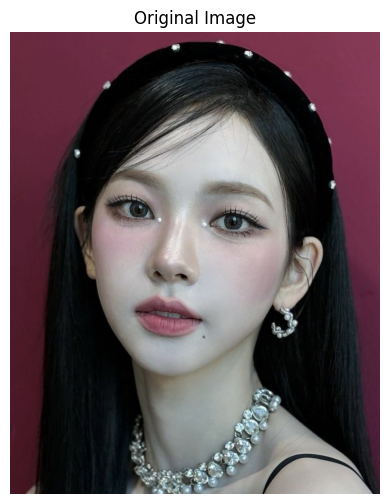

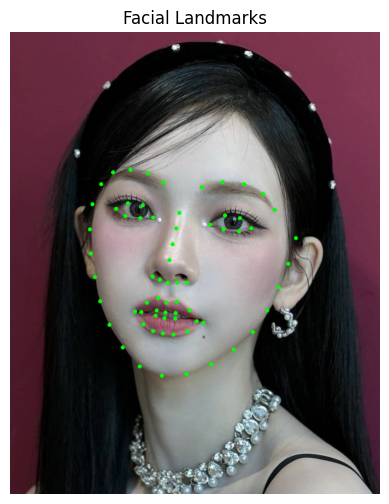

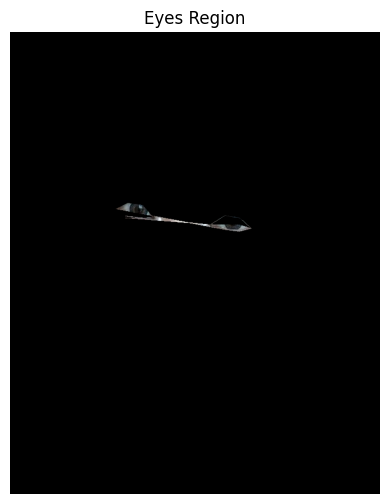

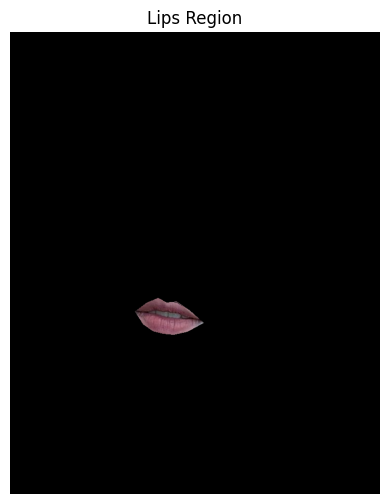

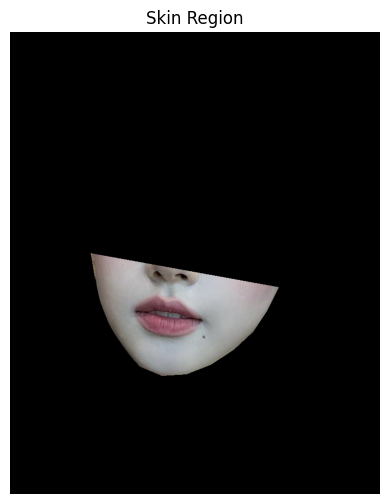

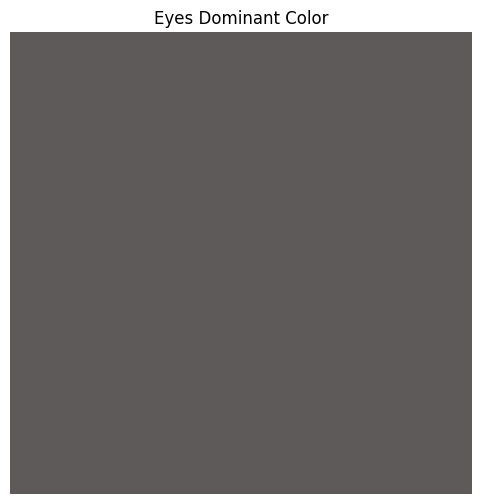

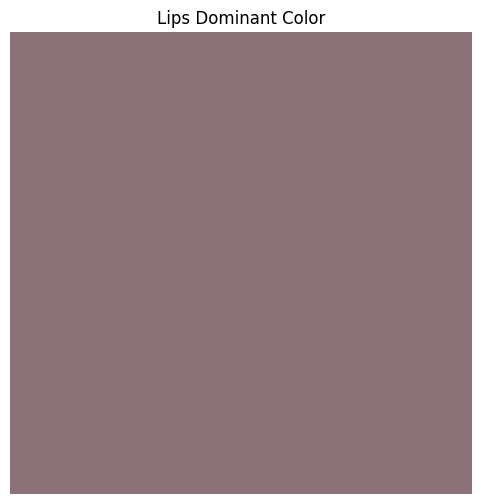

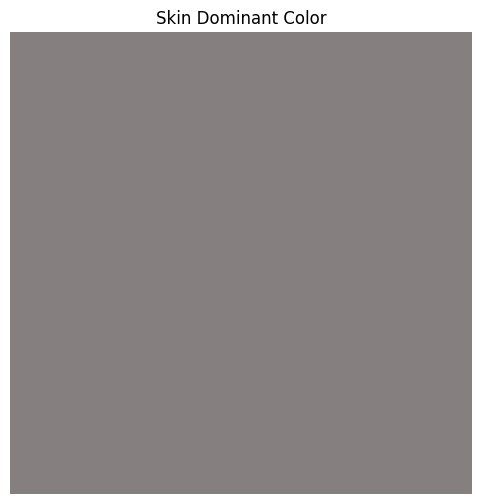

Personal Color: Winter Cool


In [19]:
classifier = PersonalColorClassifier(shape_predictor_path="shape_predictor_68_face_landmarks.dat")

image_path = "data/karina.jpeg"
image = cv2.imread(image_path)
visualize_image(image, title="Original Image")

shape = classifier.get_facial_landmarks(image)
if shape:
    # 랜드마크를 원본 이미지에 표시
    image_with_landmarks = image.copy()
    for i in range(68):
        x, y = shape.part(i).x, shape.part(i).y
        cv2.circle(image_with_landmarks, (x, y), 4, (0, 255, 0), -1)
    visualize_image(image_with_landmarks, title="Facial Landmarks")

    # 마스크를 원본 이미지에서 시각화
    image_for_mask_visualization = image.copy()

    # 눈, 입술, 피부 영역 추출
    eyes_region, lips_region, skin_region = classifier.extract_regions(image, shape)

    # 눈, 입술, 피부 영역 시각화
    mask_eyes = np.zeros(image.shape[:2], dtype=np.uint8)
    mask_lips = np.zeros(image.shape[:2], dtype=np.uint8)
    mask_skin = np.zeros(image.shape[:2], dtype=np.uint8)

    # 얼굴 랜드마크를 바탕으로 마스크 설정
    def fill_polygon(mask, indices):
        pts = [(shape.part(i).x, shape.part(i).y) for i in indices]
        pts = np.array(pts, dtype=np.int32)
        cv2.fillConvexPoly(mask, pts, 255)

    left_eye_points = [36, 37, 38, 39, 40, 41]
    right_eye_points = [42, 43, 44, 45, 46, 47]
    lip_points = list(range(48, 60))
    skin_points = list(range(2, 15))

    # 마스크 영역 채우기
    fill_polygon(mask_eyes, left_eye_points + right_eye_points)
    fill_polygon(mask_lips, lip_points)
    fill_polygon(mask_skin, skin_points)

    # 각 마스크를 원본 이미지에서 시각화
    visualize_regions(image_for_mask_visualization, mask_eyes, title="Eyes Region")
    visualize_regions(image_for_mask_visualization, mask_lips, title="Lips Region")
    visualize_regions(image_for_mask_visualization, mask_skin, title="Skin Region")

    # 대표 색상 시각화
    eyes_bgr = classifier.get_dominant_color(eyes_region)
    lips_bgr = classifier.get_dominant_color(lips_region)
    skin_bgr = classifier.get_dominant_color(skin_region)
    visualize_color(eyes_bgr, title="Eyes Dominant Color")
    visualize_color(lips_bgr, title="Lips Dominant Color")
    visualize_color(skin_bgr, title="Skin Dominant Color")

    # 최종 결과 출력
    result = classifier.classify_personal_color(eyes_bgr, lips_bgr, skin_bgr)
    print(f"Personal Color: {result}")
else:
    print("[ERROR] No face detected.")


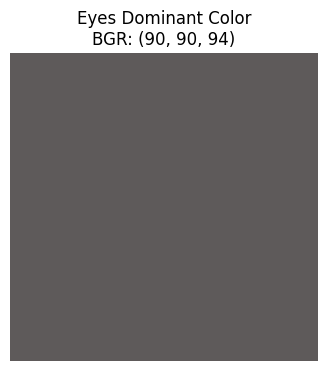

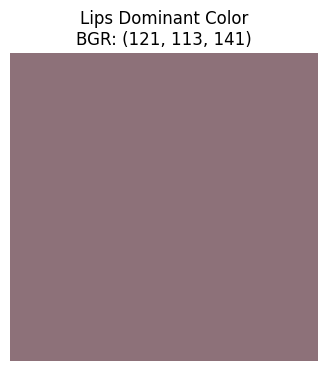

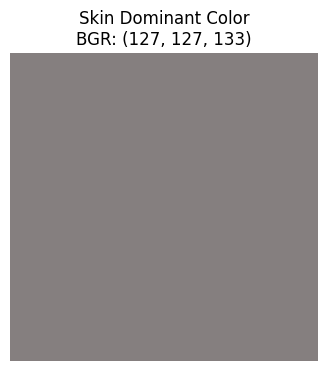

In [27]:
def visualize_dominant_color_bgr(region_bgr, title="Dominant Color (BGR)"):
    """
    K-means로 추출한 대표 색상을 단색으로 시각화
    """
    # BGR에서 RGB로 변환 (Matplotlib 호환)
    region_rgb = (region_bgr[2], region_bgr[1], region_bgr[0])
    
    # 단색 이미지 생성
    color_image = np.zeros((100, 100, 3), dtype=np.uint8)
    color_image[:] = region_bgr  # BGR 값으로 채움

    # 시각화
    plt.figure(figsize=(4, 4))
    plt.imshow(color_image[:, :, ::-1])  # BGR -> RGB 변환
    plt.title(title)
    plt.axis("off")
    plt.show()

# K-means(k=1) 대표 색상 추출
eyes_bgr = classifier.get_dominant_color(eyes_region)
lips_bgr = classifier.get_dominant_color(lips_region)
skin_bgr = classifier.get_dominant_color(skin_region)

# 대표 색상 시각화
visualize_dominant_color_bgr(eyes_bgr, title=f"Eyes Dominant Color\nBGR: {eyes_bgr}")
visualize_dominant_color_bgr(lips_bgr, title=f"Lips Dominant Color\nBGR: {lips_bgr}")
visualize_dominant_color_bgr(skin_bgr, title=f"Skin Dominant Color\nBGR: {skin_bgr}")


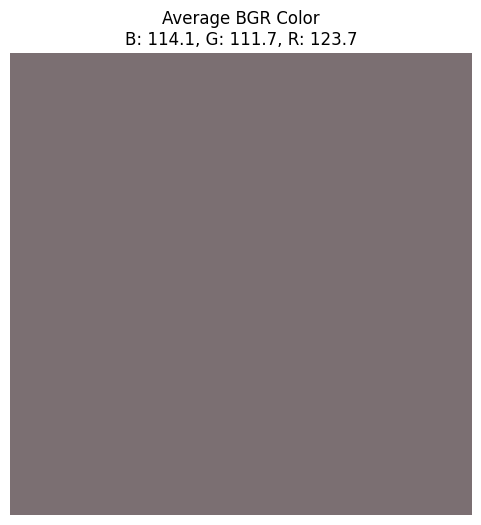

LAB Values: L=122, A=133, B=128
Personal Color Classification: Winter Cool


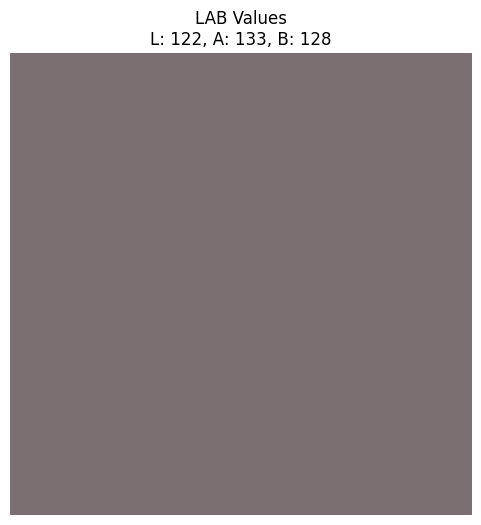

In [29]:

def classify_and_visualize_personal_color(eyes_bgr, lips_bgr, skin_bgr):
    # 1) (눈, 입술, 피부) BGR값 가중평균 계산
    avg_b = eyes_bgr[0] * 0.3 + lips_bgr[0] * 0.3 + skin_bgr[0] * 0.4
    avg_g = eyes_bgr[1] * 0.3 + lips_bgr[1] * 0.3 + skin_bgr[1] * 0.4
    avg_r = eyes_bgr[2] * 0.3 + lips_bgr[2] * 0.3 + skin_bgr[2] * 0.4

    # 2) 평균 BGR 값 시각화
    avg_bgr_color = (avg_b, avg_g, avg_r)
    avg_color_patch = np.zeros((100, 100, 3), dtype=np.uint8)
    avg_color_patch[:] = (avg_b, avg_g, avg_r)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(avg_color_patch, cv2.COLOR_BGR2RGB))  # BGR → RGB
    plt.title(f"Average BGR Color\nB: {avg_b:.1f}, G: {avg_g:.1f}, R: {avg_r:.1f}")
    plt.axis("off")
    plt.show()

    # 3) LAB 변환
    color_1x1 = np.uint8([[[avg_b, avg_g, avg_r]]])
    lab_1x1 = cv2.cvtColor(color_1x1, cv2.COLOR_BGR2LAB)[0, 0]
    L_lab, a_lab, b_lab = lab_1x1

    print(f"LAB Values: L={L_lab}, A={a_lab}, B={b_lab}")

    # 4) warm/cool 여부 판단
    if b_lab >= 138:
        warm_or_cool = "warm"
    else:
        warm_or_cool = "cool"

    # 5) spring/autumn/summer/winter 분류
    if warm_or_cool == "warm":
        if L_lab >= 147:
            season = "Spring Warm"
        else:
            season = "Autumn Warm"
    else:
        if L_lab >= 140:
            season = "Summer Cool"
        else:
            season = "Winter Cool"

    print(f"Personal Color Classification: {season}")

    # 6) 결과 시각화
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(avg_color_patch, cv2.COLOR_BGR2RGB))  # BGR → RGB
    plt.title(f"LAB Values\nL: {L_lab}, A: {a_lab}, B: {b_lab}")
    plt.axis("off")
    plt.show()

# Example BGR values (Replace with actual values)
eyes_bgr = (90, 90, 94)  # Replace with classifier.get_dominant_color(eyes_region)
lips_bgr = (121, 113, 141)  # Replace with classifier.get_dominant_color(lips_region)
skin_bgr = (127, 127, 133)  # Replace with classifier.get_dominant_color(skin_region)

classify_and_visualize_personal_color(eyes_bgr, lips_bgr, skin_bgr)
